In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Loading data
#data = np.load('data2D.npy')
data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
is_valid = True
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]


# Distance function for K-means, independent test passed
def distance_func(X, mu):
    """ Inputs:
          X: is an NxD matrix (N observations and D dimensions)
          mu: is an KxD matrix (K means and D dimensions)
          
        Output:
          pair_dist: is the squared pairwise distance matrix (NxK)
    """

    if tf.shape(X)[1] == 2: dmu = tf.cast(mu, tf.double)
    else: dmu = tf.cast(mu, tf.float32)

    pair_dist = tf.expand_dims(X, axis=1)
    pair_dist = (pair_dist - dmu) ** 2
    pair_dist = tf.reduce_sum(pair_dist, -1)

    return pair_dist

# Sum of the minimum distance between each point and clusters, independent test passed
def loss(z):
  return tf.reduce_sum(tf.reduce_min(z, axis=1))

# main training
def train(data, k):

  # init container for loss
  lossList = []

  # init mu with 3 clusters (K) and the same dimensions as data (D) using normal distribution
  mu = tf.Variable(tf.random.normal((k, dim), 0, 1, tf.double))

  # init optimizer
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)

  # start gradient descent
  for i in range(200):
    with tf.GradientTape() as g:
      g.watch(mu)
      l = loss(distance_func(data, mu))
    grad = g.gradient(l, mu)
    optimizer.apply_gradients(zip([grad], [mu]))
    lossList.append(l)

  assignment = tf.argmin(distance_func(data, mu), axis=1)
  valLoss = loss(distance_func(val_data, mu))

  if k <= 5: scatter_plot(data, k, mu, assignment, valLoss)
  
  return lossList, mu, valLoss

def scatter_plot(data, k, mu, assignment, valLoss):

  # define a list of colours
  colorList = ['b', 'g', 'c', 'm', 'y']
  
  # plot different cluster assignment iteratively with probability and colour
  plt.figure()
  for _k in range(k):
    x_cluster = data[assignment==_k, :]
    x_assign = tf.argmin(distance_func(x_cluster, mu), axis=1)
    percentage = tf.shape(x_cluster)[0] / tf.shape(data)[0]
    plt.scatter(x_cluster[:, 0], x_cluster[:, 1], s=1, c=colorList[_k], label=f'{percentage:.2f}')

  plt.legend()

  # plot cluster centers
  plt.scatter(mu[:, 0], mu[:, 1], s=30, c='red')

  # print validation loss
  txt = 'validation loss: ' + str(valLoss.numpy())
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

  return

# loss plotter
def plot_loss(lossList):

  plt.figure()
  plt.plot(lossList, label='Training Loss')
  title = "Traing Loss vs iteration"
  plt.title(title)
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.legend()
  plt.draw()

  return

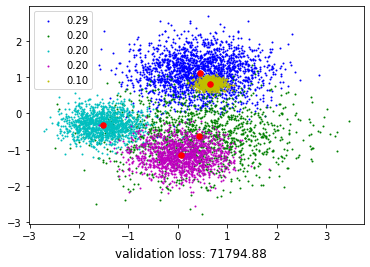

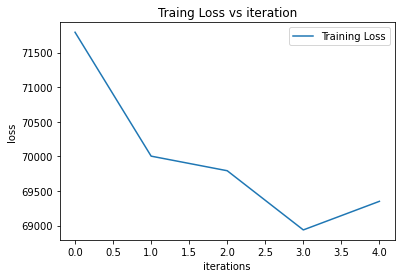

In [9]:
# number of clusters
k = [1, 2, 3, 4, 5]
bigK = [5, 10, 15, 20, 25]
# plot final loss as K changes
kLossList = []
# start training
for j in bigK:
  lossList, mu, valLoss = train(data, j)
  kLossList.append(valLoss)
plot_loss(kLossList)